<a href="https://colab.research.google.com/github/carversh/DL_sc/blob/main/analyze_results_fcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle
from scipy.optimize import linear_sum_assignment as lsa
import numpy as np
import pandas as pd
!pip install spams
import spams
!pip install mpu
import mpu
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive
import time, sys, traceback, argparse
import tqdm
import statsmodels.api as sma
import statsmodels.stats as sms
import functools
from tqdm.contrib.concurrent import thread_map
import argparse
import torch
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.utils.extmath import randomized_svd
# Mount your Google Drive
drive.mount('/content/drive', force_remount=True)

# Set the current working directory
os.chdir('/content/drive/MyDrive/AM231_project')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive


In [ ]:
def scale_effs(B, logmeanexp, downsample_num = 25000, log_exp_baseline = 2):
    '''
    Scale effect sizes to mean expression using LOWESS.

    Parameters
    ----------
    B: Perturbation x gene unscaled effect size matrix
    logmeanexp: Vector of log mean expression values to scale to
    downsample_num: Number of effects used to fit curve
    log_exp_baseline: Mean effect magnitude from this log expression is taken as the value to scale to

    Returns
    ---------
    B: Perturbation x gene scaled effect size matrix
    scale_factors: Per-gene scale factors
    '''

    data_frac = min(1, downsample_num / np.prod(B.shape))

    if B.shape[1] != len(logmeanexp):
        raise ValueError('Number of genes differs')
    rand_idx = np.c_[np.random.randint(0, B.shape[0], downsample_num),
                     np.random.randint(0, B.shape[1], downsample_num)]
    to_plot = np.c_[logmeanexp[rand_idx[:,1]], np.log(np.abs(B[rand_idx[:,0],rand_idx[:,1]]))]
    to_plot = to_plot[~np.isinf(to_plot[:,1]),:]
    fit = sma.nonparametric.lowess(to_plot[:,1], to_plot[:,0], return_sorted=False, xvals = logmeanexp)
    baseline = fit[min(i for i,x in enumerate(logmeanexp) if x > log_exp_baseline)]
    scale_factors = np.exp(fit - baseline)
    B = B / scale_factors
    return B, scale_factors

def signif(X, n):
    '''Round elements of a pandas DF X to n significant figures'''
    def func(x):
        if x == 0:
            return 0
        else:
            return round(x, n - 1 - int(np.floor(np.log10(abs(x)))))
    return X.applymap(func)

In [ ]:
def plot_effect_sizes(direc_guide, direct_conven, number_top_effect_sizes = 1000, dict_guide_file = "dictionary_guide_pooled_final_unrolled.npy", code_guide_file = "code_guide_pooled_final_unrolled.npy", dict_conven_file = "dictionary_conventional_final_unrolled.npy", code_conven_file = "code_conventional_final_unrolled.npy"):

  dict_guide = np.load(os.path.join(direc_guide,dict_guide_file)).astype(float)
  print(dict_guide.shape)
  code_guide = np.load(os.path.join(direc_guide,code_guide_file)).astype(float)
  print(code_guide.shape)
  dict_conven = np.load(os.path.join(direct_conven,dict_conven_file)).astype(float)
  print(dict_conven.shape)
  code_conven= np.load(os.path.join(direct_conven,code_conven_file)).astype(float)
  print(code_conven.shape)

  data = {'guide':{'dict':dict_guide, 'code':code_guide,'perturb_indicator_matrix':guide_pool_indicator,'genes_list':genes_guide_pooled,'perturbations_list':indic_guide,'log_mean':logmeanexp_guide_pool}, 'conven':{'dict':dict_conven, 'code':code_conven,'perturb_indicator_matrix':conventional_indicator,'genes_list':genes_guide_conven,'perturbations_list':indic_conven,'log_mean':logmeanexp_conven}}

  effect_sizes = {}
  for dataset in data.keys():
    U = spams.lasso(np.asfortranarray(data[dataset]['code']), D=np.asfortranarray(data[dataset]['perturb_indicator_matrix']), lambda1=10, verbose=False)
    B = U.dot(data[dataset]['dict'].T)
    B,_ = scale_effs(B, data[dataset]['log_mean'])

    B = pd.DataFrame(data = np.transpose(B), index = data[dataset]['genes_list'], columns = data[dataset]['perturbations_list'])
    B_final = signif(B, 3)
    effect_sizes[dataset] = B_final

  outputs = {}
  df1 = effect_sizes['guide']
  df2 = effect_sizes['conven']


  # find intersecting genes
  inter_genes = list(set(df1.index) & set(df2.index) )

  # find intersecting perturbations
  inter_perturb = list(set(df1.columns) & set(df2.columns) )

  # subset dataframes by intersections
  df1 = df1.loc[inter_genes, inter_perturb]
  df2 = df2.loc[inter_genes, inter_perturb]

  vars=list(df1.columns)
  df1_flatten = pd.melt(df1, value_vars=vars,value_name='Effect_Size', ignore_index=False)
  df1_flatten['gene'] = df1_flatten.index

  vars=list(df2.columns)
  df2_flatten = pd.melt(df2, value_vars=vars,value_name='Effect_Size', ignore_index=False)
  df2_flatten['gene'] = df2_flatten.index


  df1_flatten['abs_Effect_Size'] = df1_flatten['Effect_Size'].abs()

  sub_df1_flatten = df1_flatten.nlargest(number_top_effect_sizes, 'abs_Effect_Size', keep='all')
  sub_df1_flatten['gene'] = sub_df1_flatten.index

  merged_sub = sub_df1_flatten.merge(df2_flatten, how='left', on=['variable','gene'], left_index=False, right_index=False)
  merged_sub = merged_sub[['variable','gene','Effect_Size_x','Effect_Size_y']]
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(merged_sub[['Effect_Size_x', 'Effect_Size_y' ]]))
  outputs[f"r_sq_{number_top_effect_sizes}_top_effects"] = np.round(r_value**2,5)
  outputs[f"sq_dist_{number_top_effect_sizes}_top_effects"] = np.sum((merged_sub['Effect_Size_x'] - merged_sub['Effect_Size_y']) **2)

  merged = df1_flatten.merge(df2_flatten, how='left', on=['variable','gene'], left_index=False, right_index=False)
  slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(merged[['Effect_Size_x','Effect_Size_y']]))
  outputs["r_sq_all_effects"] = np.round(r_value**2,5)
  outputs["sq_dist_all_effects"] = np.sum((merged['Effect_Size_x'] - merged['Effect_Size_y']) **2)

  plt.plot('Effect_Size_x', 'Effect_Size_y', 'bo', data=merged)
  plt.axhline(y=0, color='black', linestyle='--')
  plt.axvline(x=0, color='black', linestyle='--')
  plt.title('All Effects')
  plt.xlabel('Guide Pooled Effect Sizes')
  plt.ylabel('Conventional Pooled Effect Sizes')
  # plt.xlim(-0.65,0.65)
  # plt.ylim(-0.65,0.65)
  plt.plot([-4.5, 4.5], [-4.5, 4.5]) # plots line y = x
  plt.xlim(-2.5,2.5)
  plt.ylim(-4.5,4.5)
  plt.show()
  plt.clf()
  plt.plot('Effect_Size_x', 'Effect_Size_y', 'bo', data=merged_sub)
  plt.axhline(y=0, color='black', linestyle='--')
  plt.axvline(x=0, color='black', linestyle='--')
  plt.title(f"Top {number_top_effect_sizes} Effects")
  plt.xlabel('Guide Pooled Effect Sizes')
  plt.ylabel('Conventional Pooled Effect Sizes')
  plt.plot([-4.5, 4.5], [-4.5, 4.5]) # plots line y = x
  plt.xlim(-4.5,4.5)
  plt.ylim(-4.5,4.5)
  plt.show()
  plt.clf()

# read in necessary dataframes
logmeanexp_guide_pool = np.load('./data/guide_pooled_processed_logmeanexp.npy')
logmeanexp_conven = np.load('./data/conventional_processed_logmeanexp.npy')

conventional_indicator = pd.read_csv('./data/GSM6858447_KO_conventional_perturbations.txt', index_col = 0, delim_whitespace=True)
indic_conven = conventional_indicator.index
keep_cells_conven = conventional_indicator.sum(axis = 0) > 0
conventional_indicator = np.asfortranarray(conventional_indicator.loc[:, keep_cells_conven].T).astype(float)
genes_guide_conven = pd.read_csv('./data/conventional_processed_gene_names.txt', sep = '\t')
genes_guide_conven = genes_guide_conven[['features']]


guide_pool_indicator =  pd.read_csv('./data/GSM6858450_KD_guide_pooled_perturbations.txt', index_col = 0, delim_whitespace=True)
indic_guide = guide_pool_indicator.index
keep_cells_guide_pool = guide_pool_indicator.sum(axis = 0) > 0
guide_pool_indicator = np.asfortranarray(guide_pool_indicator.loc[:, keep_cells_guide_pool].T).astype(float)
genes_guide_pooled = pd.read_csv('./data/guide_pooled_processed_gene_names.txt', sep = '\t')
genes_guide_pooled = genes_guide_pooled[['features']]

In [ ]:
def dict_code_similarity_both(filepath1, guide_pool=False, conven=False):
                  # dictionary () , code (CELLS x ATOMS)
  plt.figure(figsize=(10,5))
  a = 9000
  b = 200


  if guide_pool:
    code_dict1 = np.load(os.path.join(filepath1,"code_guide_pooled_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_code_KD_guide_pooled.npy')
  if conven:
    code_dict1 = np.load(os.path.join(filepath1,"code_conventional_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_code_conventional.npy')

  # correct dimensions
  if code_dict1.shape[0] < code_dict1.shape[1]:
    code_dict1 = code_dict1.T
  if code_dict2.shape[0] < code_dict2.shape[1]:
    code_dict2 = code_dict2.T
  plt.plot(np.sum(np.abs(code_dict1[a:a+b, :]),axis=1), color="green", label='Pytorch code')
  plt.plot(np.sum(np.abs(code_dict2[a:a+b, :]),axis=1), color="black", label='SPAMS code')
  plt.title('Code Similarity')
  plt.legend()
  plt.show()
  plt.clf()

  if guide_pool:
    code_dict1 = np.load(os.path.join(filepath1,"dictionary_guide_pooled_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy')
  if conven:
    code_dict1 = np.load(os.path.join(filepath1,"dictionary_conventional_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_dictionary_conventional.npy')

  # correct dimensions
  if code_dict1.shape[0] < code_dict1.shape[1]:
    code_dict1 = code_dict1.T
  if code_dict2.shape[0] < code_dict2.shape[1]:
    code_dict2 = code_dict2.T
  plt.plot(np.sum(np.abs(code_dict1[a:a+b, :]),axis=1), color="blue", label='Pytorch dict')
  plt.plot(np.sum(np.abs(code_dict2[a:a+b, :]),axis=1), color="red", label='SPAMS dict')
  plt.title('Dictionary Similarity')
  plt.show()
  plt.legend()
  plt.clf()



In [ ]:
def dict_code_similarity_on_atoms(filepath1, guide_pool=False, conven=False):
                  # dictionary () , code (CELLS x ATOMS)
  plt.figure(figsize=(10,5))


  if guide_pool:
    code_dict1 = np.load(os.path.join(filepath1,"code_guide_pooled_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_code_KD_guide_pooled.npy')
  if conven:
    code_dict1 = np.load(os.path.join(filepath1,"code_conventional_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_code_conventional.npy')

  # correct dimensions
  if code_dict1.shape[0] < code_dict1.shape[1]:
    code_dict1 = code_dict1.T
  if code_dict2.shape[0] < code_dict2.shape[1]:
    code_dict2 = code_dict2.T
  plt.plot(np.sum(np.abs(code_dict1),axis=0), color="green", label='Pytorch code')
  plt.plot(np.sum(np.abs(code_dict2),axis=0), color="black", label='SPAMS code')
  plt.legend()
  plt.show()
  plt.clf()

  if guide_pool:
    code_dict1 = np.load(os.path.join(filepath1,"dictionary_guide_pooled_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy')
  if conven:
    code_dict1 = np.load(os.path.join(filepath1,"dictionary_conventional_final_unrolled.npy"))
    code_dict2 = np.load('./data/SPAMS_output/SPAMS_dictionary_conventional.npy')

  # correct dimensions
  if code_dict1.shape[0] < code_dict1.shape[1]:
    code_dict1 = code_dict1.T
  if code_dict2.shape[0] < code_dict2.shape[1]:
    code_dict2 = code_dict2.T
  plt.plot(np.sum(np.abs(code_dict1),axis=0), color="blue", label='Pytorch dict')
  plt.plot(np.sum(np.abs(code_dict2),axis=0), color="red", label='SPAMS dict')


  plt.legend()
  plt.show()
  plt.clf()



In [ ]:
# computes similarity between dictionaries
# inputted dictionaries must be genes by modules
def dictionary_distance(d, dhat, permute=True, eps=1e-6):

    assert d.shape == dhat.shape # make suer dictionaries are the same shape
    m, p = d.shape # m = genes, p = atoms

    # d = d.clone()
    # dhat = dhat.clone()

    d = d
    dhat = dhat

    d /= torch.norm(d, keepdim=True, dim=0) # divide by norm so that the l2 norm sums to 1 (dividing every entry of the column by the norm)
    dhat /= torch.norm(dhat, keepdim=True, dim=0)

    d = torch.nan_to_num(d) # set NA to 0
    dhat = torch.nan_to_num(dhat)

    cost = torch.zeros(p, p) # make atom by atom matrix to store error in similarity

    for i in range(p):
        for j in range(p):
            a = 1 - torch.dot(d[:, i], dhat[:, j]).pow(2)
            cost[i, j] = torch.sqrt(a + eps)
    p = lsa(cost) if permute else (np.arange(p), np.arange(p))

    return cost[p], cost[p].median(), cost[p].max()

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_1000_update_lasso_5_lambda_0.1_laplacian_True_epochs_200_2023_05_19_16_06_06/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_1000_update_lasso_5_lambda_0.1_laplacian_True_epochs_200_2023_05_19_16_35_05/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)

(15668, 10)
(24192, 10)


FileNotFoundError: ignored

(15668, 10)
(24192, 10)
(16952, 10)
(86956, 10)


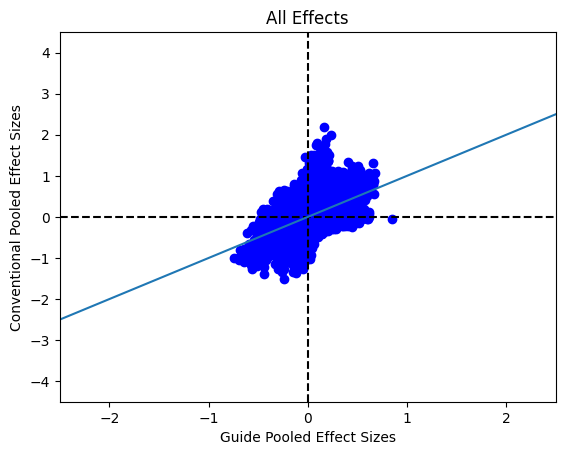

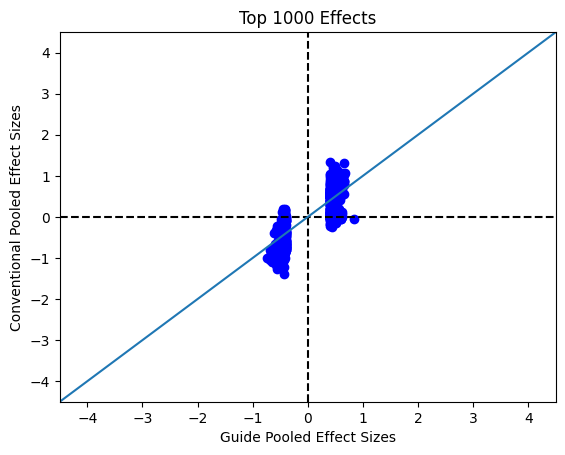

<Figure size 640x480 with 0 Axes>

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_0_250_epochs_update_lasso_per_it_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_16_23_57/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_0_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_20_00_19/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)

(15668, 10)
(24192, 10)
(16952, 10)
(86956, 10)


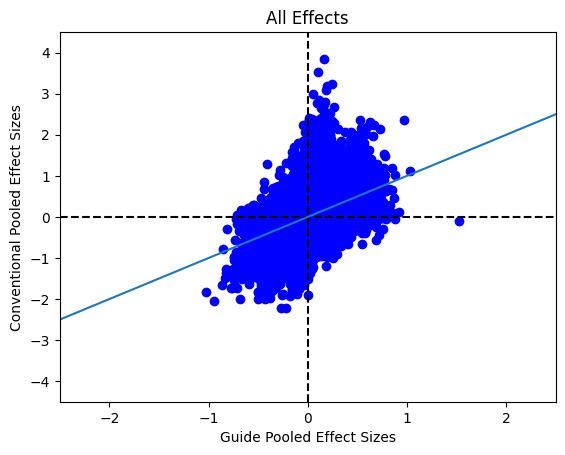

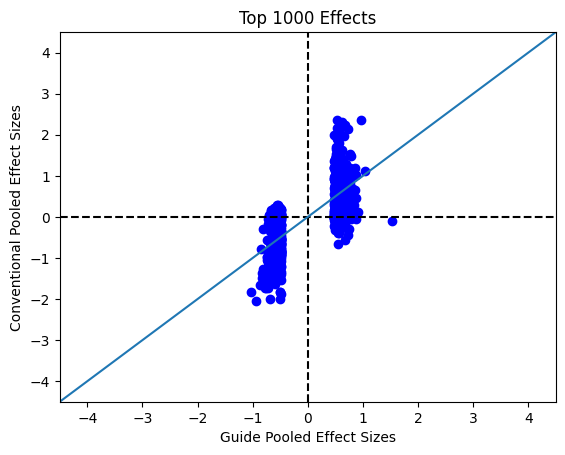

<Figure size 640x480 with 0 Axes>

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_100_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_03_10_55_54/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_100_update_lasso_5_init_pytorch_reduce_LR_lambda_0.1_laplacian_True_epochs_250_2023_06_04_03_17_03/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)


(15668, 10)
(24192, 10)
(16952, 10)
(86956, 10)


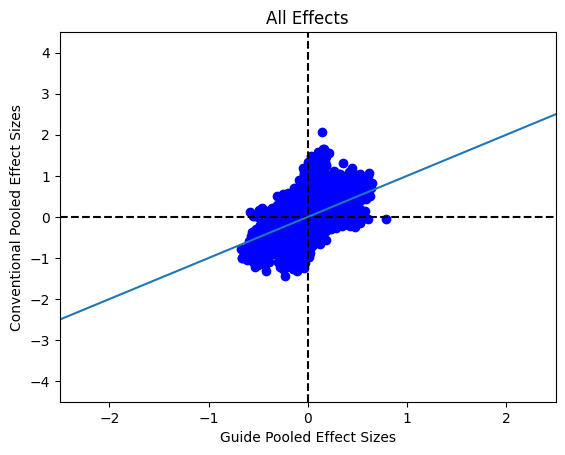

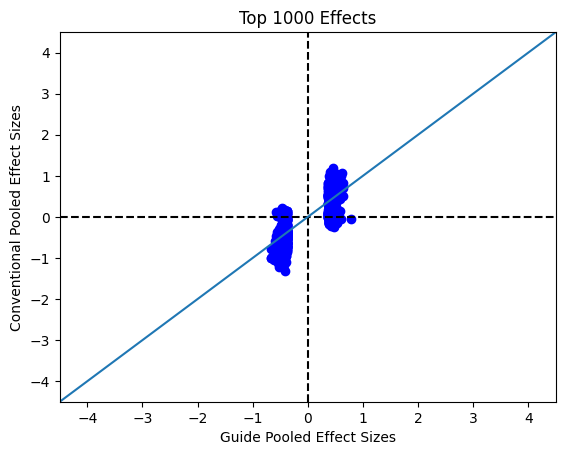

<Figure size 640x480 with 0 Axes>

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_00_12/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_512_initial_dict_data_lambda_0.1_laplacian_False_epochs_200_2023_05_16_21_25_03/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)

(15668, 10)
(24192, 10)
(16952, 10)
(86956, 10)


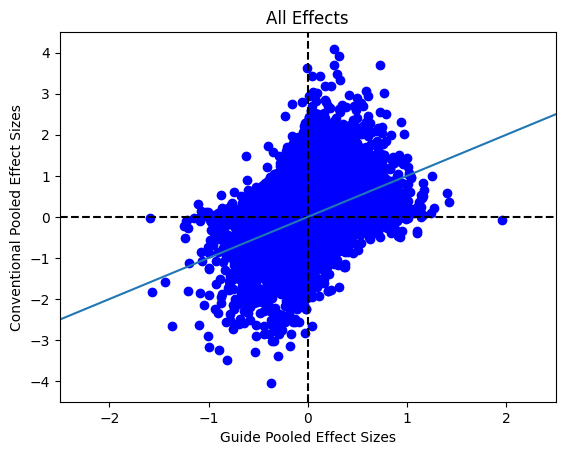

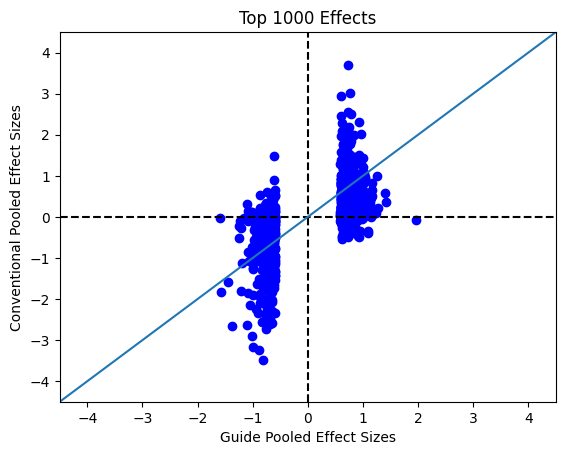

<Figure size 640x480 with 0 Axes>

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_1000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_01_22_01/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_1000_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_200_2023_05_18_01_52_06/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)


In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_1000_update_lasso_5_init_pytorch_lambda_0.1_laplacian_True_epochs_200_2023_05_29_21_44_47/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_1000_update_lasso_5_init_pytorch_lambda_0.1_laplacian_True_epochs_200_2023_05_29_22_31_14/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)

In [ ]:
d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_2084_true_lambda_0.1_laplacian_False_epochs_200_2023_05_12_15_46_55/dictionary_guide_pooled_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('guide pool cost', cost_rand)
print('guide pool cost', median)
print('guide pool cost', max)

d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_conventional.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_true_lambda_0.1_laplacian_False_epochs_200_2023_05_12_16_10_37/dictionary_conventional_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('conven cost', cost_rand)
print('conven cost', median)
print('conven cost', max)

guide pool cost tensor([0.8493, 0.8140, 0.8605, 0.6775, 0.7023, 0.9534, 0.7078, 0.6507, 0.7897,
        0.7895])
guide pool cost tensor(0.7895)
guide pool cost tensor(0.9534)
conven cost tensor([0.8496, 0.8022, 0.9205, 0.8760, 0.8567, 0.6557, 0.6616, 0.7490, 0.8780,
        0.9106])
conven cost tensor(0.8496)
conven cost tensor(0.9205)


In [ ]:
d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_02_58_57/dictionary_guide_pooled_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('guide pool cost', cost_rand)
print('guide pool cost', median)
print('guide pool cost', max)

d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_conventional.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_03_58_08/dictionary_conventional_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('conven cost', cost_rand)
print('conven cost', median)
print('conven cost', max)

guide pool cost tensor([0.9123, 0.8471, 0.7707, 0.8533, 0.7998, 0.8834, 0.5607, 0.6508, 0.7364,
        0.9676])
guide pool cost tensor(0.7998)
guide pool cost tensor(0.9676)
conven cost tensor([0.7641, 0.7479, 0.8326, 0.8826, 0.8404, 0.8093, 0.7044, 0.5864, 0.8712,
        0.7188])
conven cost tensor(0.7641)
conven cost tensor(0.8826)


In [ ]:
sum([0.9123, 0.8471, 0.7707, 0.8533, 0.7998, 0.8834, 0.5607, 0.6508, 0.7364,
        0.9676])

7.9821

In [ ]:
sum([0.7641, 0.7479, 0.8326, 0.8826, 0.8404, 0.8093, 0.7044, 0.5864, 0.8712,
        0.7188])

7.7577

In [ ]:
d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_39_23/dictionary_guide_pooled_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('guide pool cost', cost_rand)
print('guide pool cost', median)
print('guide pool cost', max)

d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_conventional.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_21_04_07/dictionary_conventional_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('conven cost', cost_rand)
print('conven cost', median)
print('conven cost', max)

guide pool cost tensor([0.9004, 0.7731, 0.7764, 0.8762, 0.7563, 0.8666, 0.8562, 0.7752, 0.8475,
        0.5239])
guide pool cost tensor(0.7764)
guide pool cost tensor(0.9004)
conven cost tensor([0.7864, 0.7167, 0.8922, 0.7836, 0.6214, 0.9128, 0.9019, 0.7302, 0.7178,
        0.7691])
conven cost tensor(0.7691)
conven cost tensor(0.9128)


In [ ]:
print(d.shape)
print(dhat.shape)

torch.Size([16952, 10])
torch.Size([16952, 10])


In [ ]:
sum([0.9004, 0.7731, 0.7764, 0.8762, 0.7563, 0.8666, 0.8562, 0.7752, 0.8475,
        0.5239])
z.shape

torch.Size([30, 10])

In [ ]:
a = np.random.randint(0, z_org.shape[0])
b = 50
a

54070

In [ ]:
z_org = torch.t(torch.tensor(np.load('./data/SPAMS_output/SPAMS_code_KD_guide_pooled.npy') , dtype=torch.float32) )
zhat_org = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_39_23/code_guide_pooled_final_unrolled.npy") , dtype=torch.float32)
a = np.random.randint(0, z_org.shape[0])
b = 50
z = z_org[a:a+b,:]
zhat = zhat_org[a:a+b,:]
(cost_rand, median, max ) = dictionary_distance(z, zhat)
print('guide pool cost', cost_rand)
print('guide pool cost', median)
print('guide pool cost', max)

z_org = torch.t(torch.tensor(np.load('./data/SPAMS_output/SPAMS_code_conventional.npy') , dtype=torch.float32) )
zhat_org = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_21_04_07/code_conventional_final_unrolled.npy") , dtype=torch.float32)
z = z_org[a:a+b,:]
zhat = zhat_org[a:a+b,:]
(cost_rand, median, max ) = dictionary_distance(z, zhat)
print('conven cost', cost_rand)
print('conven cost', median)
print('conven cost', max)

guide pool cost tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
guide pool cost tensor(1.0000)
guide pool cost tensor(1.0000)
conven cost tensor([0.9397, 0.9773, 0.9734, 0.9980, 0.9641, 0.9838, 0.9826, 0.9979, 0.9351,
        0.9607])
conven cost tensor(0.9734)
conven cost tensor(0.9980)


In [ ]:
*******after

In [ ]:
d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_KD_guide_pooled.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_0_250_epochs_update_lasso_per_it_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_16_23_57/dictionary_guide_pooled_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('guide pool cost all:', cost_rand)
print('guide pool cost median:', median)
print('guide pool cost max:', max)

d = torch.tensor(np.load('./data/SPAMS_output/SPAMS_dictionary_conventional.npy') , dtype=torch.float32)
dhat = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_0_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_20_00_19/dictionary_conventional_final_unrolled.npy") , dtype=torch.float32)
(cost_rand, median, max ) = dictionary_distance(d, dhat)
print('conven cost all:', cost_rand)
print('conven cost median:', median)
print('conven cost max:', max)

guide pool cost all: tensor([0.8524, 0.7772, 0.7899, 0.7883, 0.9385, 0.5748, 0.7693, 0.7036, 0.7159,
        0.8128])
guide pool cost median: tensor(0.7772)
guide pool cost max: tensor(0.9385)
conven cost all: tensor([0.7312, 0.8918, 0.9030, 0.8193, 0.7835, 0.8009, 0.8558, 0.8506, 0.7185,
        0.8147])
conven cost median: tensor(0.8147)
conven cost max: tensor(0.9030)


In [ ]:
z_org = torch.t(torch.tensor(np.load('./data/SPAMS_output/SPAMS_code_KD_guide_pooled.npy') , dtype=torch.float32) )
zhat_org = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_0_250_epochs_update_lasso_per_it_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_16_23_57/code_guide_pooled_final_unrolled.npy") , dtype=torch.float32)
a = np.random.randint(0, z_org.shape[0])
b = 50
z = z_org[a:a+b,:]
zhat = zhat_org[a:a+b,:]
(cost_rand, median, max ) = dictionary_distance(z, zhat)
print('guide pool cost all:', cost_rand)
print('guide pool cost median:', median)
print('guide pool cost max:', max)

z_org = torch.t(torch.tensor(np.load('./data/SPAMS_output/SPAMS_code_conventional.npy') , dtype=torch.float32) )
zhat_org = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_0_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_20_00_19/code_conventional_final_unrolled.npy") , dtype=torch.float32)
z = z_org[a:a+b,:]
zhat = zhat_org[a:a+b,:]
(cost_rand, median, max ) = dictionary_distance(z, zhat)
print('conven cost all:', cost_rand)
print('conven cost median:', median)
print('conven cost max:', max)

#filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/conventional_lapl_genes_0_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_20_00_19/"
#dict_code_similarity_both(filepath1=filepath1, conven=True)



guide pool cost all: tensor([0.8014, 0.8776, 0.8495, 0.5977, 0.6718, 0.4084, 0.6774, 0.6976, 0.7943,
        0.8315])
guide pool cost median: tensor(0.6976)
guide pool cost max: tensor(0.8776)
conven cost all: tensor([0.5662, 0.9359, 0.8093, 0.8547, 0.7019, 0.7213, 0.8372, 0.8065, 0.7609,
        0.8837])
conven cost median: tensor(0.8065)
conven cost max: tensor(0.9359)


In [ ]:
*** before

In [ ]:
z_org = torch.t(torch.tensor(np.load('./data/SPAMS_output/SPAMS_code_KD_guide_pooled.npy') , dtype=torch.float32) )
zhat_org = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_02_58_57/code_guide_pooled_final_unrolled.npy") , dtype=torch.float32)
z = z_org[a:a+b,:]
zhat = zhat_org[a:a+b,:]
(cost_rand, median, max ) = dictionary_distance(z, zhat)
print('guide pool cost', cost_rand)
print('guide pool cost', median)
print('guide pool cost', max)

z_org = torch.t(torch.tensor(np.load('./data/SPAMS_output/SPAMS_code_conventional.npy') , dtype=torch.float32) )
zhat_org = torch.tensor(np.load("/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_03_58_08/code_conventional_final_unrolled.npy") , dtype=torch.float32)
z = z_org[a:a+b,:]
zhat = zhat_org[a:a+b,:]
(cost_rand, median, max ) = dictionary_distance(z, zhat)
print('conven cost', cost_rand)
print('conven cost', median)
print('conven cost', max)


guide pool cost tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])
guide pool cost tensor(1.0000)
guide pool cost tensor(1.0000)
conven cost tensor([1.0000, 0.9558, 0.9124, 0.9664, 0.9793, 0.9646, 0.9920, 0.9845, 0.9890,
        0.9956])
conven cost tensor(0.9793)
conven cost tensor(1.0000)


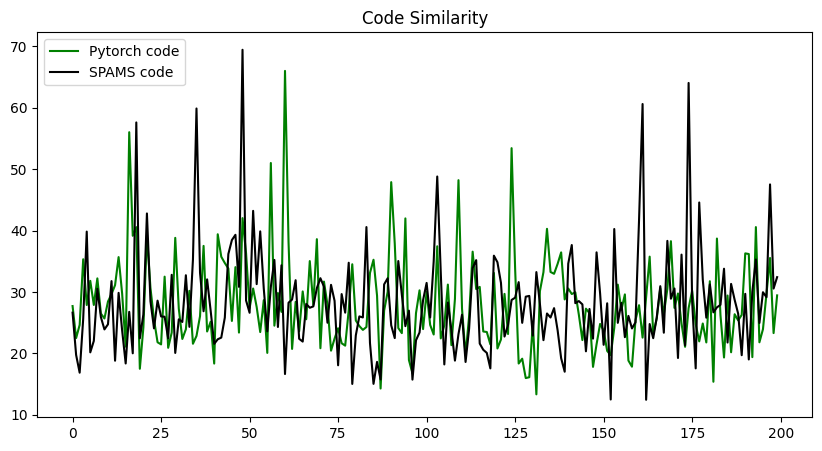

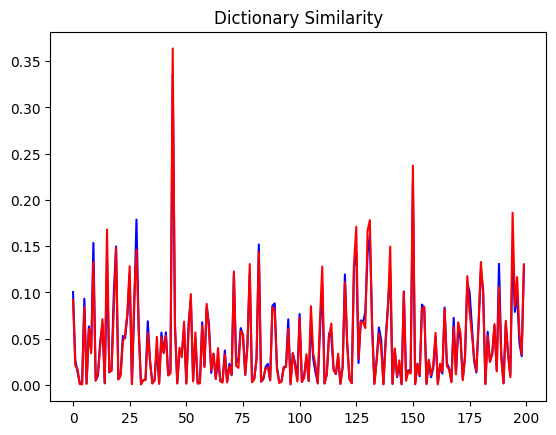

<Figure size 640x480 with 0 Axes>

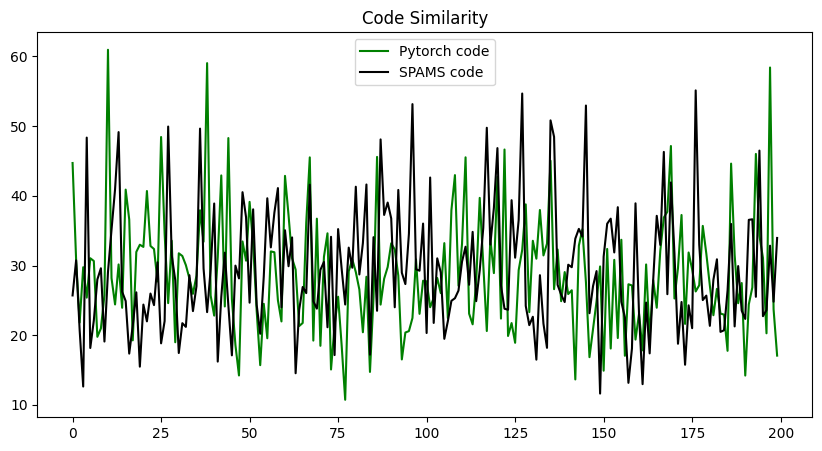

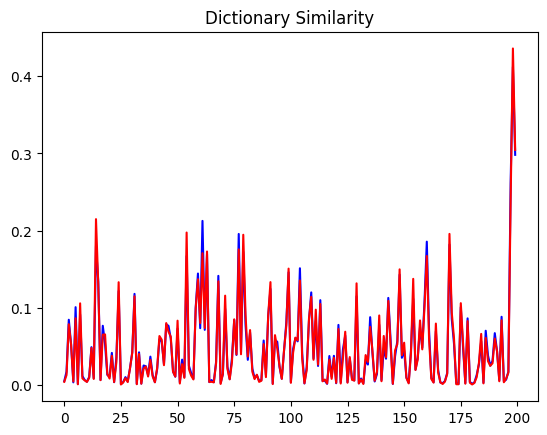

<Figure size 640x480 with 0 Axes>

In [ ]:
filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_03_58_08/"
dict_code_similarity_both(filepath1=filepath1, conven=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_02_58_57/"
dict_code_similarity_both(filepath1=filepath1, guide_pool=True)

In [ ]:
**** NEXT IS MOST RECENT

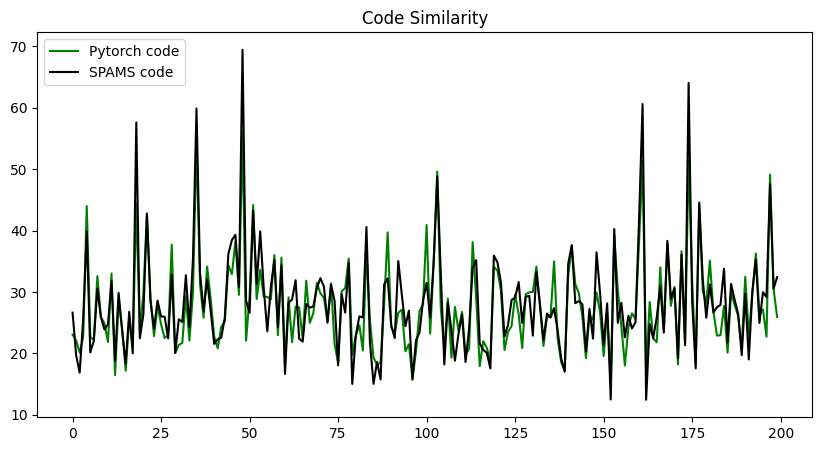

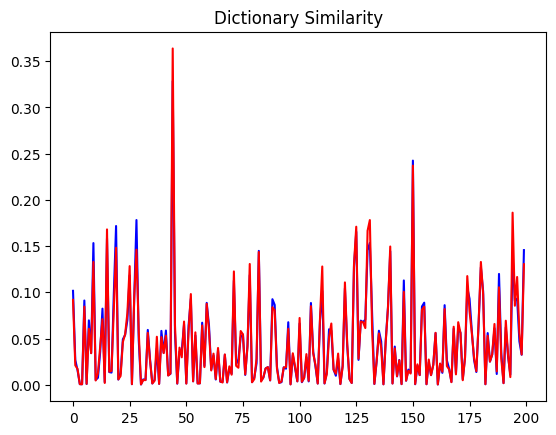

<Figure size 640x480 with 0 Axes>

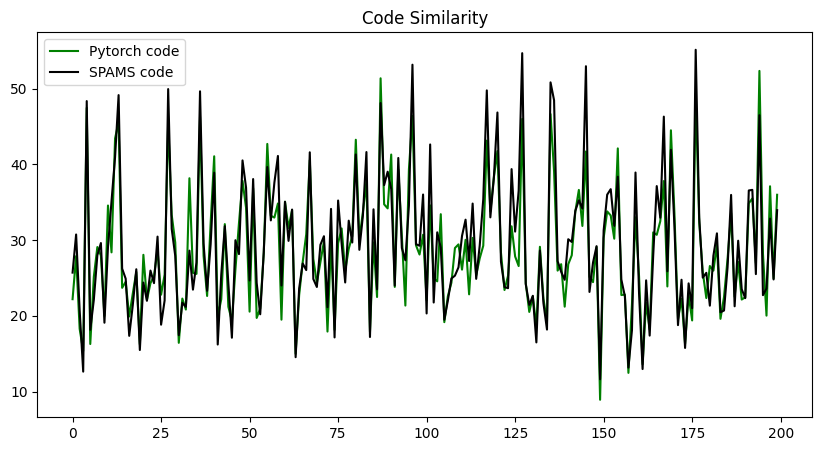

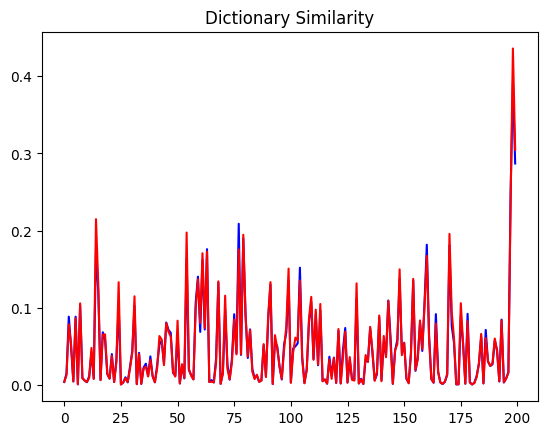

<Figure size 640x480 with 0 Axes>

In [ ]:
filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_lapl_genes_0_batch_512_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_20_00_19/"
dict_code_similarity_both(filepath1=filepath1, conven=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_lapl_genes_0_250_epochs_update_lasso_per_it_initial_dict_data_lambda_0.1_laplacian_True_epochs_250_2023_06_06_16_23_57/"
dict_code_similarity_both(filepath1=filepath1, guide_pool=True)

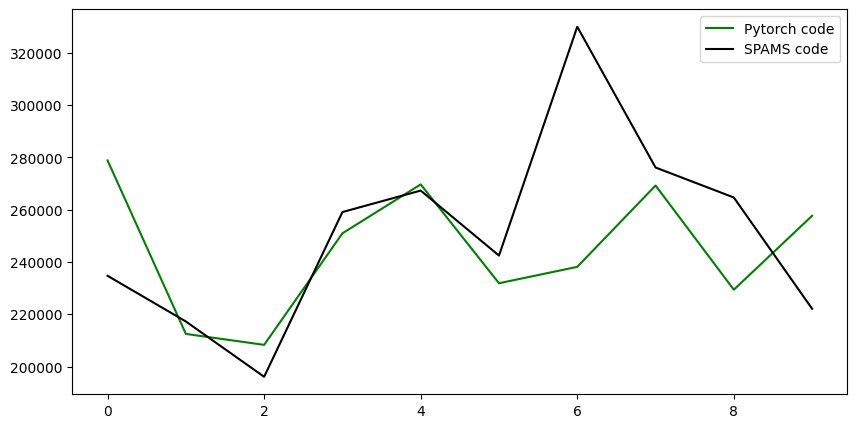

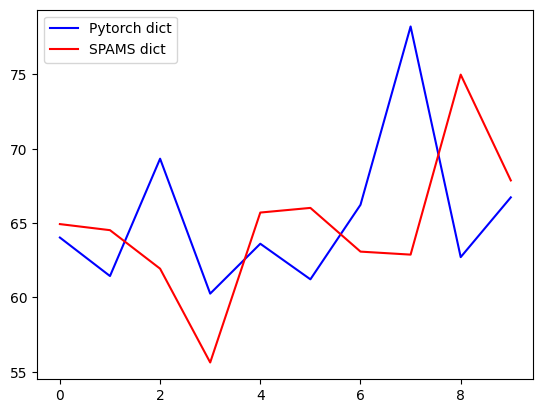

<Figure size 640x480 with 0 Axes>

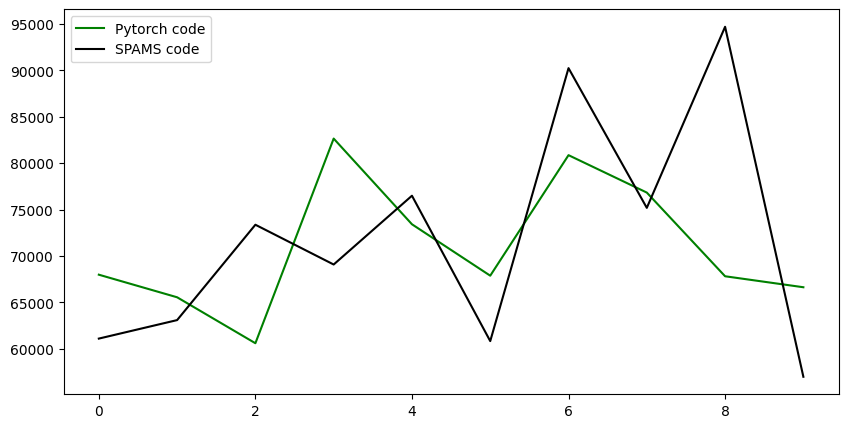

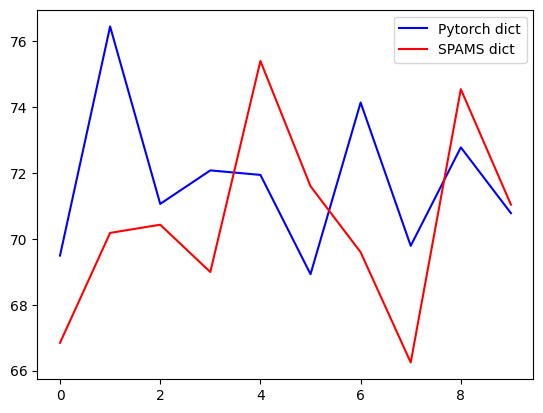

<Figure size 640x480 with 0 Axes>

In [ ]:
filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_03_58_08/"
dict_code_similarity_on_atoms(filepath1=filepath1, conven=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_02_58_57/"
dict_code_similarity_both(filepath1=filepath1, guide_pool=True)

(15668, 10)
(24192, 10)
(16952, 10)
(86956, 10)


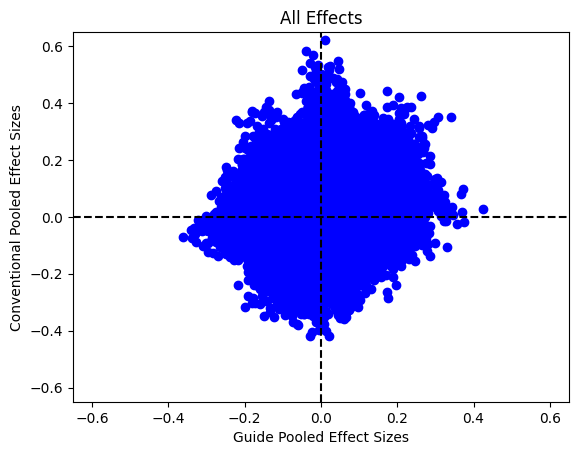

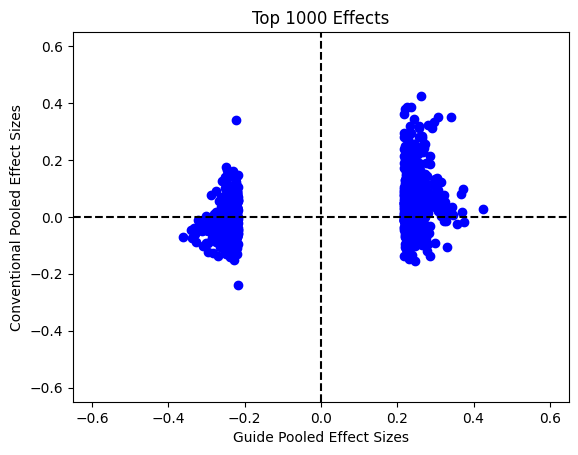

<Figure size 640x480 with 0 Axes>

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_02_58_57/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_03_58_08/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)

code
dict
code
dict


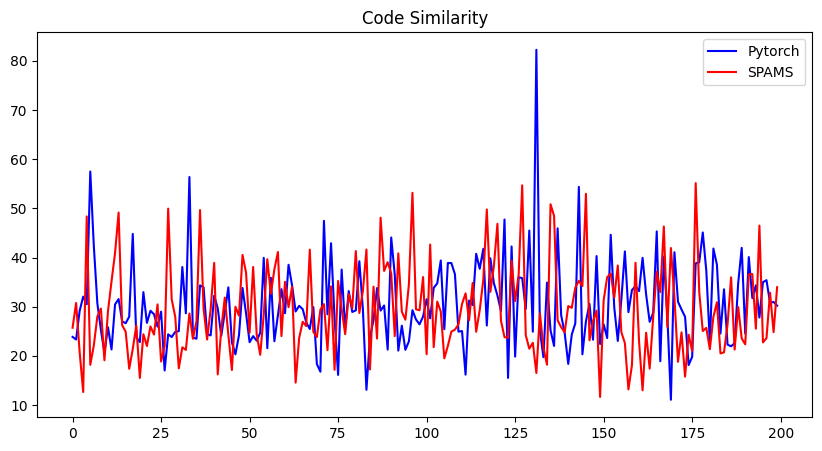

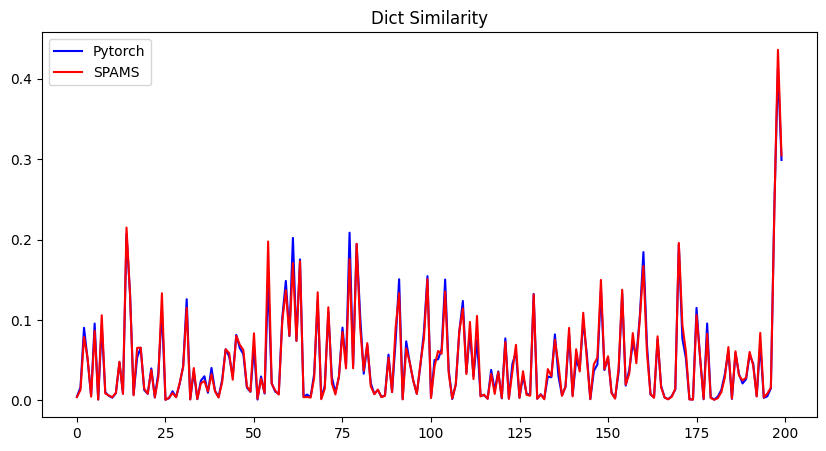

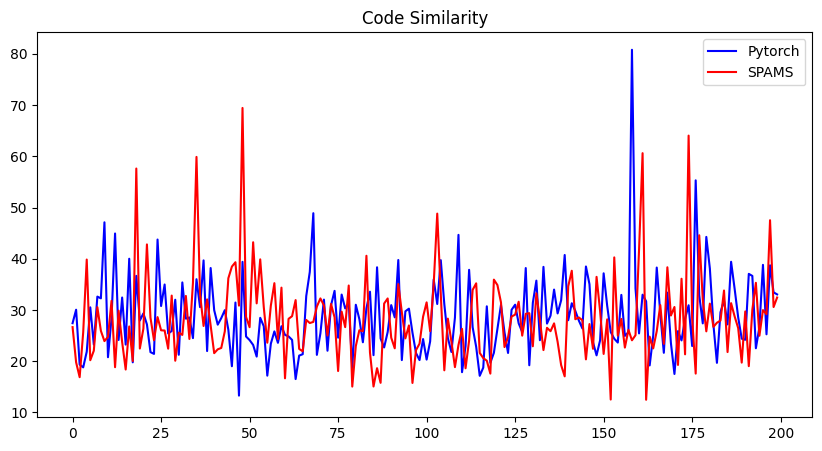

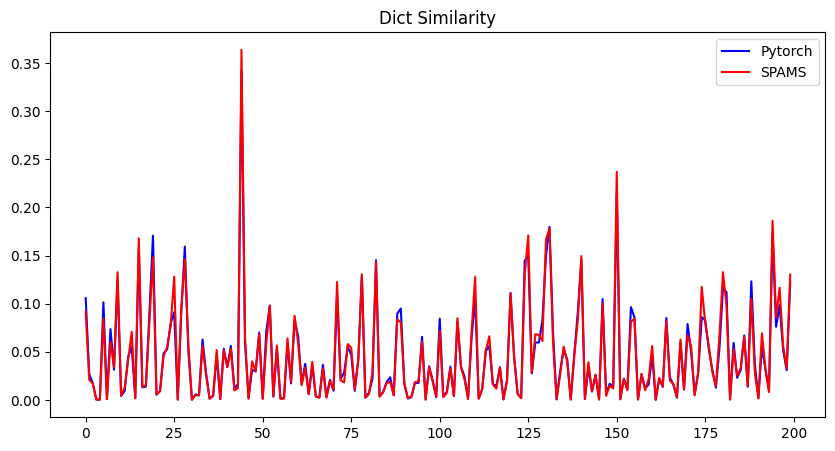

In [ ]:
filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_delay_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_51_48/"
dict_code_similarity(filepath1=filepath1, code=True, guide_pool=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_delay_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_51_48/"
dict_code_similarity(filepath1=filepath1, Dict=True, guide_pool=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_delay_lambda_0.1_laplacian_False_epochs_100_2023_05_08_22_04_20/"
dict_code_similarity(filepath1=filepath1, code=True, conven=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_delay_lambda_0.1_laplacian_False_epochs_100_2023_05_08_22_04_20/"
dict_code_similarity(filepath1=filepath1, Dict=True, conven=True)


code
dict
code
dict


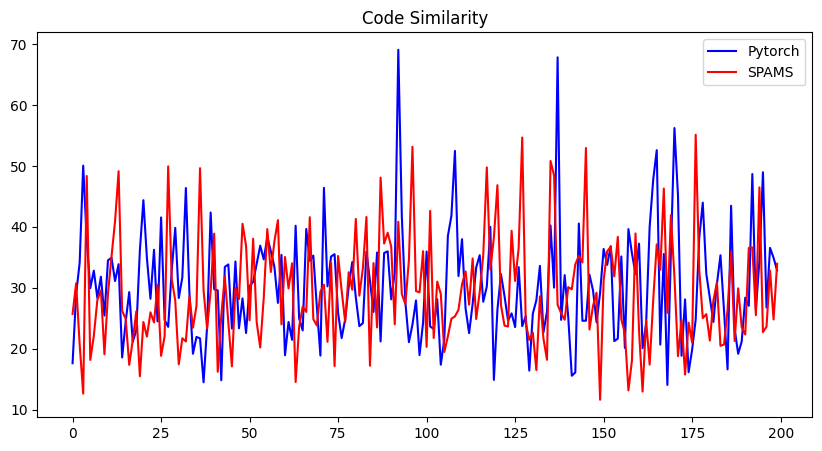

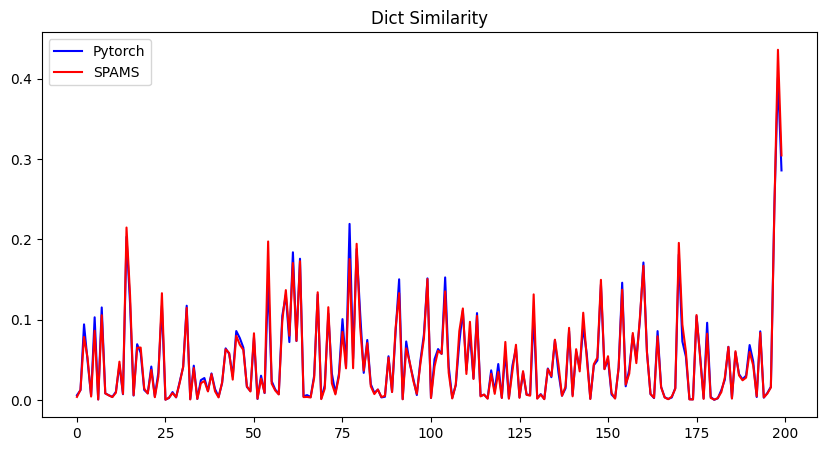

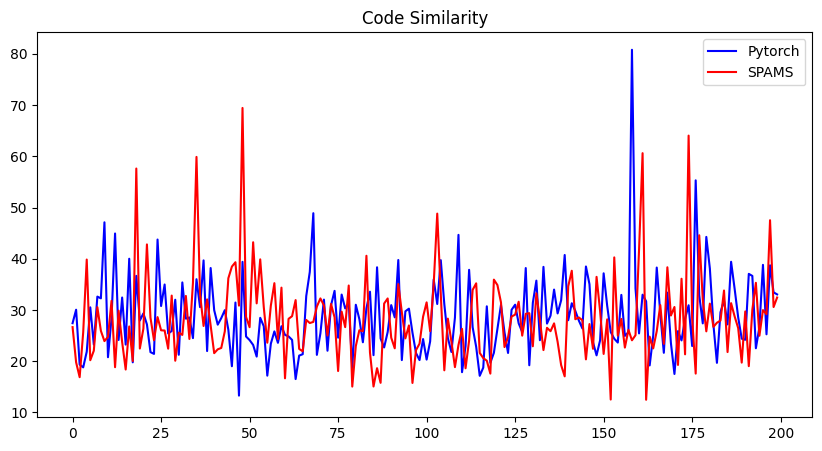

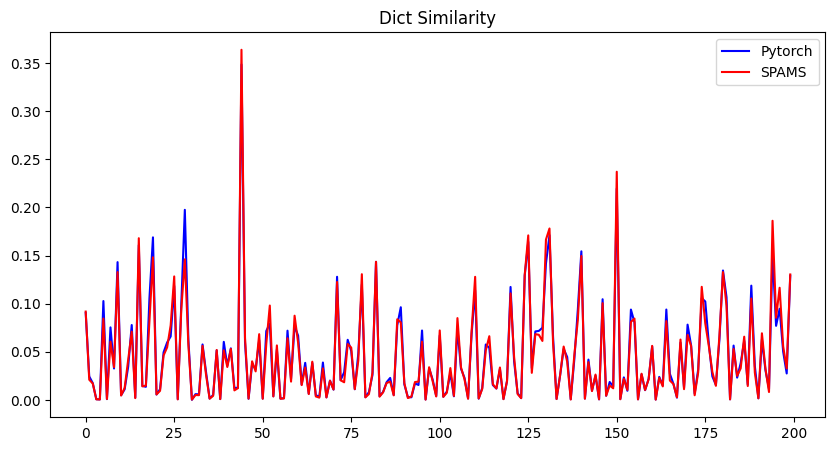

In [ ]:
filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_39_23/"
dict_code_similarity(filepath1=filepath1, code=True, guide_pool=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_39_23/"
dict_code_similarity(filepath1=filepath1, Dict=True, guide_pool=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_delay_lambda_0.1_laplacian_False_epochs_100_2023_05_08_22_04_20/"
dict_code_similarity(filepath1=filepath1, code=True, conven=True)

filepath1 = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_21_04_07/"
dict_code_similarity(filepath1=filepath1, Dict=True, conven=True)


(15668, 10)
(24192, 10)
(16952, 10)
(86956, 10)


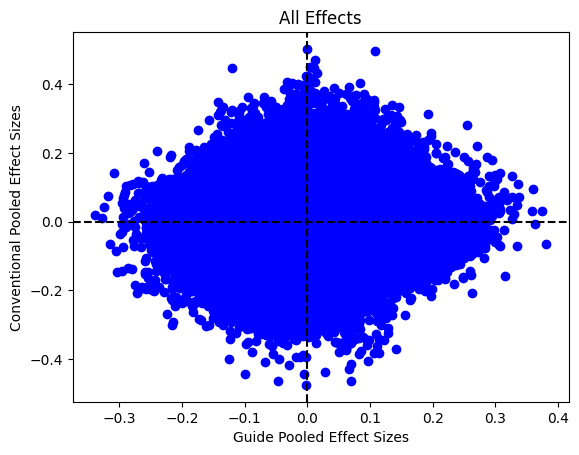

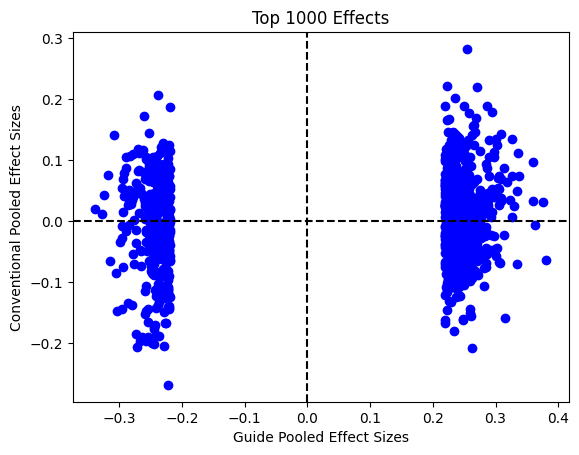

(15668, 10)
(24192, 10)
(16952, 10)
(86956, 10)


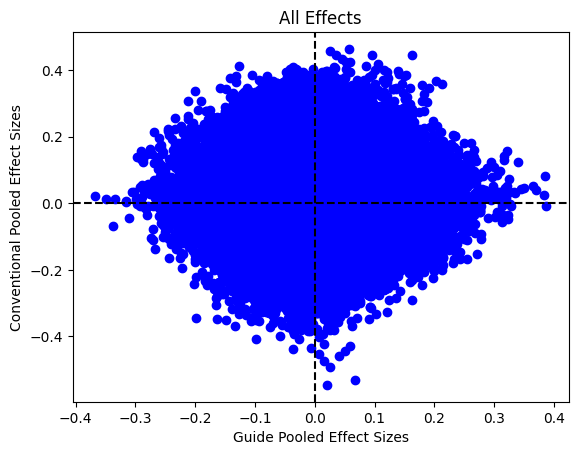

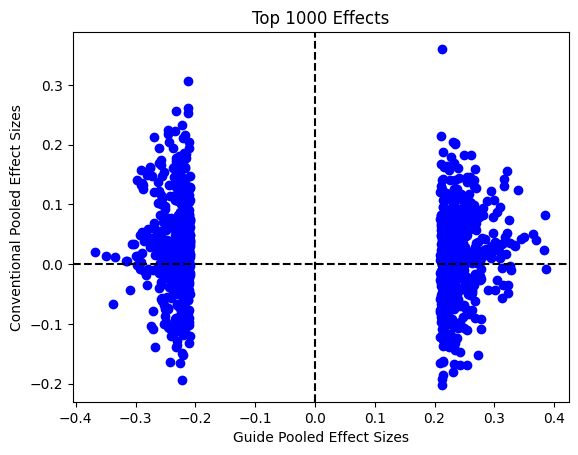

<Figure size 640x480 with 0 Axes>

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_delay_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_51_48/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_delay_lambda_0.1_laplacian_False_epochs_100_2023_05_08_22_04_20/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)

direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_20_39_23/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_high_eps_initial_lambda_0.1_laplacian_False_epochs_100_2023_05_08_21_04_07/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)

In [ ]:
direc_guide = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/conventional_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_03_58_08/"
direct_conven = "/content/drive/MyDrive/AM231_project/data/logs/tensorboard/train/guide_pooled_batch_2084_lambda_0.1_laplacian_False_epochs_500_2023_05_12_02_58_57/"
plot_effect_sizes(direc_guide = direc_guide, direct_conven=direct_conven)